# Electricity Transformer EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This dataset has been obtained from: https://github.com/zhouhaoyi/ETDataset/tree/main (ETTm1)

In [5]:
data = pd.read_csv('../../data/raw/electricity_transformer.csv')

In [3]:
data.head(3)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000


In [4]:
data.tail(3)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432,9.426
69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523,9.426
69679,2018-06-26 19:45:00,12.994,3.818,8.244,1.777,4.721,1.523,9.778


We have two years of data, in which each data point is recorded every 15 minutes, from a certain region of a province of China. The dataset contains 69,680 data points. Each data point consists of 8 features, including the date of the point, the predictive value **OT** (Oil Temperature), and 6 different types of external power load features:

- HUFL: High UseFul Load
- HULL: High UseLess Load
- MUFL: Middle UseFul Load			
- MULL: Middle UseLess Load
- LUFL: Low UseFul Load
- LULL: Low UseLess Load

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69680 entries, 0 to 69679
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69680 non-null  object 
 1   HUFL    69680 non-null  float64
 2   HULL    69680 non-null  float64
 3   MUFL    69680 non-null  float64
 4   MULL    69680 non-null  float64
 5   LUFL    69680 non-null  float64
 6   LULL    69680 non-null  float64
 7   OT      69680 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [11]:
data.isna().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

## Oil temperature

We start now with the brief study of our target. First of all, we are going to plot the time series:

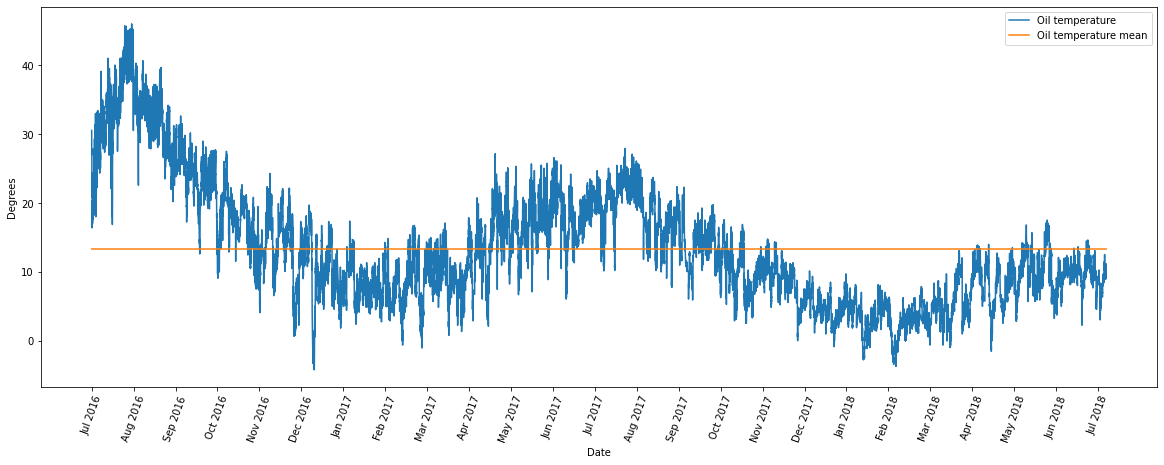

In [79]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(data)), data.OT, label='Oil temperature')
ticks_x = pd.date_range(start='2016/07', end='2018/08', freq='M') 
labels_x = [i.strftime('%b %Y') for i in ticks_x]
plt.xticks(range(0, len(data), 4*24*30), labels_x, rotation=70)
plt.plot(len(data)*[data.OT.mean()], label='Oil temperature mean')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Degrees')
plt.show(block=False)

We can observe that there exists a seasonal trend, every 12 months the oil temperature increases (then it isn't a stationary series). It is difficult to see more patterns here so we are going to do some additional plots now.

Let's do a seasonal plot assuming a yearly period:

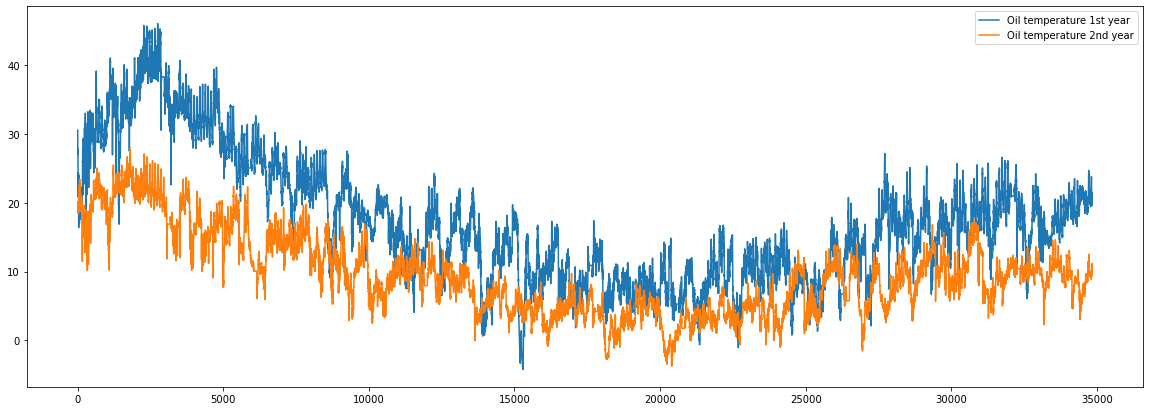

In [43]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(data)/2), data.OT[:int(len(data)/2)], label='Oil temperature 1st year')
plt.plot(np.arange(len(data)/2), data.OT[int(len(data)/2):], label='Oil temperature 2nd year')
plt.legend()
plt.show(block=False)

We can conclude from this that assuming a period of a year is quite correct because both lines are approximately parallel and also we are going to assume that the variance of the series is constant over time. 

Now we start with the ACFs:

<Figure size 1152x1296 with 0 Axes>

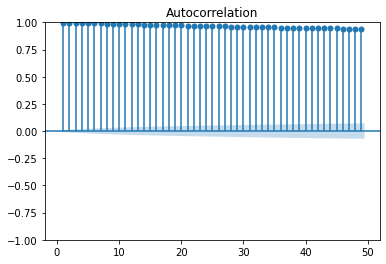

In [27]:
plt.figure(figsize=(16,18))
plot_acf(data.OT, zero=False)
plt.show()

As the coefficients of the ACF of the series are greater than zero and decay slowly and approximately linearly, it suggests that we have to differentiate it at least once. 

In [15]:
dif1 = data.OT.diff()

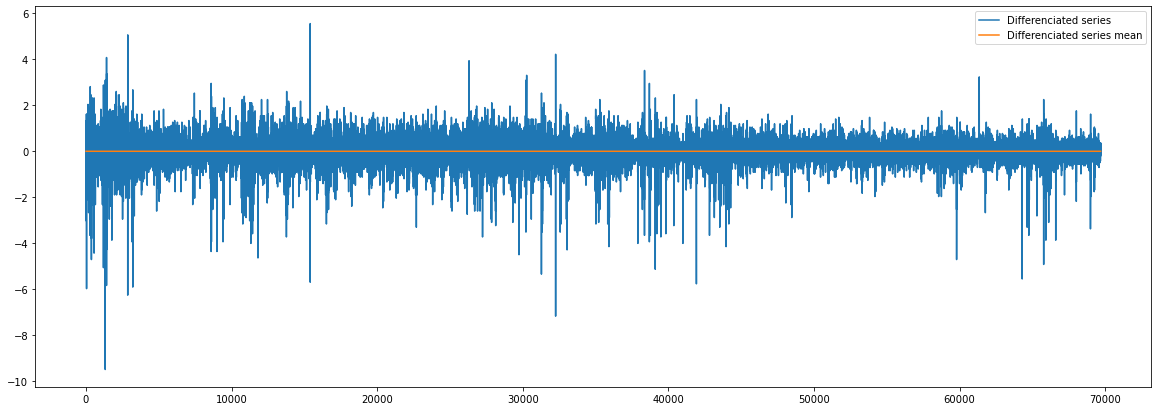

In [17]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(dif1)), dif1, label='Differenciated series')
plt.plot(len(dif1)*[dif1.mean()], label='Differenciated series mean')
plt.legend()
plt.show(block=False)

In [18]:
dif1.mean()

-0.0002978372287116563

Now, we can assume that the mean is constant and equal to zero so we stop the differentiation. Let's see its ACF:

<Figure size 1152x1296 with 0 Axes>

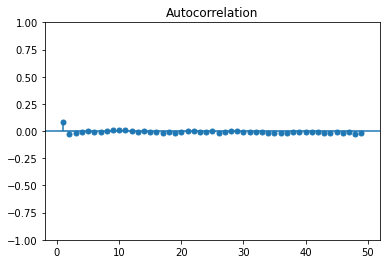

In [76]:
plt.figure(figsize=(16,18))
plot_acf(dif1[1:], zero=False)
plt.show()

We can't see anything clear here and there are few values, so let's do an analytic prove:

In [66]:
acf_values, confint = sm.tsa.acf(dif1[1:], nlags=len(dif1[1:])-1, alpha=0.05)

lags_oob = 0
index_oob = []

for i in range(len(acf_values)):
    if confint[i][0] > acf_values[i] or confint[i][1] < acf_values[i]:
        lags_oob += 1
        index_oob.append(i)

In [67]:
lags_oob

0

Surprisingly, every coefficient of the ACF of the differenciated series is statistically null which means that it doesn't exist correlation between past values  of the series and its current value in any lag. This result is a bit suspicious and it could be affected by the huge amount of data points that makes the bounds values become tiny.

<Figure size 1152x1296 with 0 Axes>

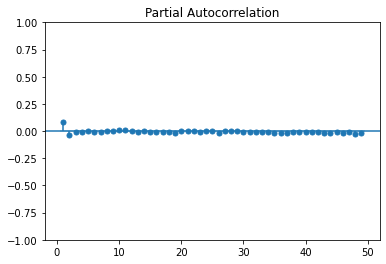

In [30]:
plt.figure(figsize=(16,18))
plot_pacf(dif1[1:], zero=False)
plt.show()

It happens the same as with the ACF:

In [72]:
pacf_values, confint = sm.tsa.pacf(dif1[1:], nlags=1000, alpha=0.05)

lags_oob = 0
index_oob = []

for i in range(len(pacf_values)):
    if confint[i][0] > pacf_values[i] or confint[i][1] < pacf_values[i]:
        lags_oob += 1
        index_oob.append(i)

In [73]:
lags_oob

0

We obtain the same as in the ACF and probably due to the same reason.

Then, the only clear conclusion we can obtain from this quick study is that out time series has a big autocorrelation of lag one but it would be strange that if we enhance our future models with more previouses lags they don't work even better.

In [1]:
import seaborn as sns

<AxesSubplot:>

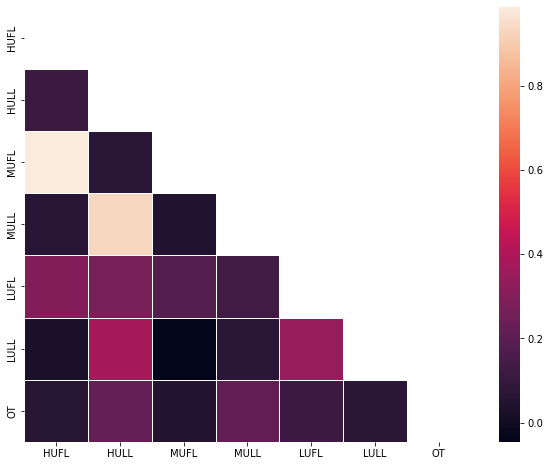

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), linewidth=0.5, mask = np.triu(np.ones_like(data.corr(), dtype=bool)))

Here we can observe that the target is not correlated with the rest of features, so we are not going to add  these lagged variables to our dataset.